# Import Packages

In [142]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot

In [2]:
import mysql.connector
from mysql.connector import errorcode
import config

# Load FLIGHTS data from MySQL

In [5]:
# Connect to database
dbname = 'FLIGHTS'
cnx = mysql.connector .connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    db = dbname
)
cursor = cnx.cursor()

In [26]:
# Get FLIGHTS data from MySQL
cursor.execute('''SELECT flight_id, date, origin, origin_city, dest, dest_city, dep_delay, arr_delay FROM FLIGHTS.FLIGHTS''')
flights_data = cursor.fetchall()
flights_df = pd.DataFrame(flights_data)

# Get column names for flights dataframe
field_names = [i[0] for i in cursor.description]
flights_df.columns = field_names

In [28]:
flights_df.head()

,flight_id,date,origin,origin_city,dest,dest_city,dep_delay,arr_delay
0,1,2018-12-01,JFK,"New York, NY",LAX,"Los Angeles, CA",-4.0,-26.0
1,2,2018-12-01,JFK,"New York, NY",LAX,"Los Angeles, CA",-6.0,-19.0
2,3,2018-12-01,JFK,"New York, NY",LAX,"Los Angeles, CA",-2.0,-15.0
3,4,2018-12-01,JFK,"New York, NY",MIA,"Miami, FL",-3.0,46.0
4,5,2018-12-01,JFK,"New York, NY",LAX,"Los Angeles, CA",-7.0,11.0


In [152]:
flights_df.dropna(inplace = True)
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50812 entries, 0 to 51222
Data columns (total 8 columns):
flight_id      50812 non-null int64
date           50812 non-null object
origin         50812 non-null object
origin_city    50812 non-null object
dest           50812 non-null object
dest_city      50812 non-null object
dep_delay      50812 non-null float64
arr_delay      50812 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 3.5+ MB


In [153]:
# Group data by origin city
nyc = flights_df[flights_df['origin_city'] == 'New York, NY']
la = flights_df[flights_df['origin_city'] == 'Los Angeles, CA']
mi = flights_df[flights_df['origin_city'] == 'Miami, FL']

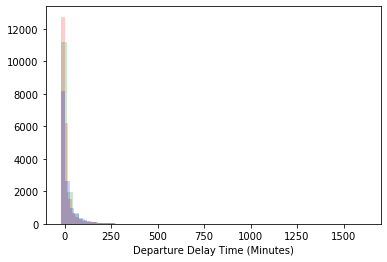

In [154]:
# Plot overlapping histograms of departure time delay (minutes)
plt.hist(nyc['dep_delay'], bins = 50, alpha = 0.2, color = 'red');
plt.hist(la['dep_delay'], bins = 50, alpha = 0.2, color = 'green');
plt.hist(mi['dep_delay'], bins = 50, alpha = 0.2, color = 'blue');
plt.xlabel('Departure Delay Time (Minutes)');

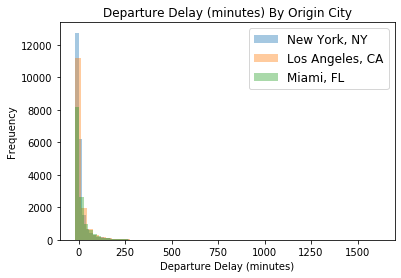

In [159]:
sns.distplot(nyc['dep_delay'], kde = False, label = 'New York, NY');
sns.distplot(la['dep_delay'], kde = False, label = 'Los Angeles, CA');
sns.distplot(mi['dep_delay'], kde = False, label = 'Miami, FL');
plt.legend(prop={'size': 12});
plt.title('Departure Delay (minutes) By Origin City');
plt.xlabel('Departure Delay (minutes)');
plt.ylabel('Frequency');

In [165]:
# Calculate standard deviation of departure delay by origin city
print(flights_df.groupby('origin_city')['dep_delay'].std())
print(flights_df.groupby('origin_city').size())

origin_city
Los Angeles, CA    48.651462
Miami, FL          54.746669
New York, NY       44.156540
Name: dep_delay, dtype: float64
origin_city
Los Angeles, CA    14559
Miami, FL          13401
New York, NY       22852
dtype: int64


# ANOVA Departure Delay ~ Origin

$H_0$ : $D_{New York}$ = $D_{Los Angeles}$ = $D_{Miami}$

$H_A$ : $H_0$ is false

In [188]:
anova_origin_city = ols('dep_delay~origin', data = flights_df).fit()
anova_origin_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dep_delay   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     58.60
Date:                Thu, 14 Nov 2019   Prob (F-statistic):           8.23e-38
Time:                        14:45:26   Log-Likelihood:            -2.6925e+05
No. Observations:               50812   AIC:                         5.385e+05
Df Residuals:                   50808   BIC:                         5.386e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.2493      0.378     32.386      0.000      11.508      12.991
origin[T.LAX]     1.4713      0.552      2.668      0.008       0.390       2.552
origin[T.LGA]    -0.7802      0.712     -1.096      0.273      -2.175       0.615
origin[T.MIA]     6.6772      0.564     11.839      0.000       5.572       7.783
==============================================================================
Omnibus:                    70395.635   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         30560048.140
Skew:                           7.955   Prob(JB):                         0.00
Kurtosis:                     122.085   Cond. No.                         4.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [197]:
anova_table = sm.stats.anova_lm(anova_origin_city, type=2)

In [198]:
print(anova_table)

               df        sum_sq        mean_sq          F        PR(>F)
origin        3.0  4.123687e+05  137456.244336  58.602951  8.234868e-38
Residual  50808.0  1.191728e+08    2345.551561        NaN           NaN


In [199]:
esq_sm = anova_table['sum_sq'][0]/(anova_table['sum_sq'][0] + anova_table['sum_sq'][1])
anova_table['EtaSq'] = [esq_sm, 'NaN']
print(anova_table)

               df        sum_sq        mean_sq          F        PR(>F)  \
origin        3.0  4.123687e+05  137456.244336  58.602951  8.234868e-38   
Residual  50808.0  1.191728e+08    2345.551561        NaN           NaN   

               EtaSq  
origin    0.00344833  
Residual         NaN  


# Load Weather Data

In [71]:
dbname = 'FLIGHTS'
cnx = mysql.connector .connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    db = dbname
)
cursor = cnx.cursor()

In [72]:
cursor.execute('''SELECT date, city_name, precip_intens, precip_type, max_temp, min_temp, visibility, wind_gust FROM FLIGHTS.WEATHER''')
weather_data = cursor.fetchall()
weather_df = pd.DataFrame(weather_data)
weather_df.shape
field_names = [i[0] for i in cursor.description]
weather_df.columns = field_names

In [73]:
weather_df.head()

,date,city_name,precip_intens,precip_type,max_temp,min_temp,visibility,wind_gust
0,2013-07-01,"Los Angeles, CA",0.0000,None,96.03,67.18,9.731,10.36
1,2013-07-01,"Miami, FL",0.0010,rain,88.47,78.40,9.997,18.00
2,2013-07-01,"New York, NY",0.0324,rain,76.39,72.88,5.383,9.41
3,2013-07-02,"Los Angeles, CA",0.0000,None,85.97,65.60,8.973,12.53
4,2013-07-02,"Miami, FL",0.0027,rain,85.29,76.65,9.923,15.46


# Merge Flight and Weather Data

In [74]:
flight_weather = pd.merge(flights_df, weather_df,  how = 'left', left_on=['date','origin_city'], right_on = ['date','city_name'])

In [75]:
flight_weather.head()

,flight_id,date,origin,origin_city,dest,dest_city,dep_delay,arr_delay,city_name,precip_intens,precip_type,max_temp,min_temp,visibility,wind_gust
0,1,2018-12-01,JFK,"New York, NY",LAX,"Los Angeles, CA",-4.0,-26.0,"New York, NY",0.0011,rain,45.13,40.53,9.663,5.51
1,2,2018-12-01,JFK,"New York, NY",LAX,"Los Angeles, CA",-6.0,-19.0,"New York, NY",0.0011,rain,45.13,40.53,9.663,5.51
2,3,2018-12-01,JFK,"New York, NY",LAX,"Los Angeles, CA",-2.0,-15.0,"New York, NY",0.0011,rain,45.13,40.53,9.663,5.51
3,4,2018-12-01,JFK,"New York, NY",MIA,"Miami, FL",-3.0,46.0,"New York, NY",0.0011,rain,45.13,40.53,9.663,5.51
4,5,2018-12-01,JFK,"New York, NY",LAX,"Los Angeles, CA",-7.0,11.0,"New York, NY",0.0011,rain,45.13,40.53,9.663,5.51


# Clean Precipitation Type

In [173]:
import matplotlib.pyplot as plt

In [174]:
flight_weather['precip_type'].value_counts()

rain     18003
snow       587
sleet       67
Name: precip_type, dtype: int64

In [175]:
# Check that missing preciptation type is because precipitation intensity was 0
weather_none = flight_weather[flight_weather['precip_type'].isnull()]
print(len(weather_none))
weather_precip_0 = flight_weather[(flight_weather['precip_intens'] == 0) & (flight_weather['precip_type'].isnull())]
print(len(weather_precip_0))

32566
32566


In [176]:
flight_weather_precip = flight_weather.fillna(value = {'precip_type': 'No Precipitation'})

In [177]:
print(flight_weather_precip.groupby('precip_type')['dep_delay'].std())
print(flight_weather_precip.groupby('precip_type').size())

precip_type
No Precipitation    42.722932
rain                58.148282
sleet               19.241085
snow                42.504249
Name: dep_delay, dtype: float64
precip_type
No Precipitation    32566
rain                18003
sleet                  67
snow                  587
dtype: int64


# ANOVA Departure Delay Time ~ Precipitation Type

$H_0$ : $D_{no rain}$ = $D_{rain}$
    
$H_A$ : $H_0$ is false

In [201]:
formula = 'dep_delay~precip_type'
anova_precip = ols(formula, data = flight_weather_precip).fit()
print(anova_precip.summary())
anova_table1 = sm.stats.anova_lm(anova_precip, typ=2)

                            OLS Regression Results                            
Dep. Variable:              dep_delay   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     117.1
Date:                Thu, 14 Nov 2019   Prob (F-statistic):           1.38e-75
Time:                        14:48:12   Log-Likelihood:            -2.7061e+05
No. Observations:               51021   AIC:                         5.412e+05
Df Residuals:                   51017   BIC:                         5.413e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               11.4063 

In [202]:
esq_sm1 = anova_table1['sum_sq'][0]/(anova_table1['sum_sq'][0] + anova_table1['sum_sq'][1])
anova_table1['EtaSq'] = [esq_sm1, 'NaN']
print(anova_table1)

                   sum_sq       df           F        PR(>F)       EtaSq
precip_type  8.322750e+05      3.0  117.120151  1.377664e-75  0.00684002
Residual     1.208451e+08  51017.0         NaN           NaN         NaN


# ANOVA Departure Delay ~ Origin + Precipitation Type

$H_0$ : $D_{New York}$ = $D_{Los Angeles}$ = $D_{Miami}$

$H_A$ : $H_0$ is false

$H_0$ : $D_{no rain}$ = $D_{rain}$

$H_A$ : $H_0$ is false

$H_0$ : There is no interaction between origin city and precipitation

$H_A$ : $H_0$ is false

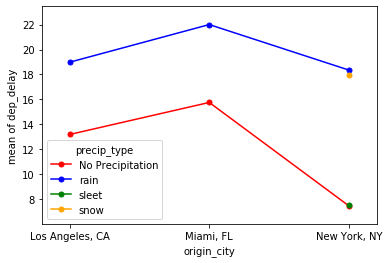

In [206]:
fig = interaction_plot(x = flight_weather_precip.origin_city, 
                       trace = flight_weather_precip.precip_type, 
                       response = flight_weather_precip.dep_delay, 
                       colors = ['red', 'blue', 'green', 'orange'], ms=10)

In [207]:
flight_weather_twoway = flight_weather_precip[flight_weather_precip['precip_type'].isin(['No Precipitation', 'rain'])]

In [208]:
flight_weather_precip['precip_type'].value_counts()

No Precipitation    32566
rain                18003
snow                  587
sleet                  67
Name: precip_type, dtype: int64

In [209]:
flight_weather_twoway['precip_type'].value_counts()

No Precipitation    32566
rain                18003
Name: precip_type, dtype: int64

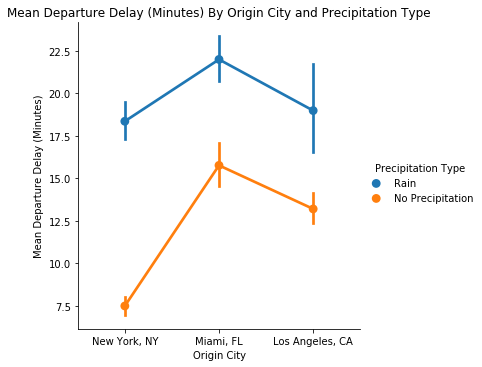

In [233]:
interaction_plot = sns.catplot(x = 'origin_city', y = 'dep_delay', 
                               hue = 'precip_type', kind = 'point', 
                               data = flight_weather_twoway);
interaction_plot.set(xlabel = 'Origin City', ylabel = 'Mean Departure Delay (Minutes)', 
                     title = 'Mean Departure Delay (Minutes) By Origin City and Precipitation Type')
interaction_plot._legend.set_title('Precipitation Type')
for cat, label in zip(interaction_plot._legend.texts,('Rain', 'No Precipitation')):
    cat.set_text(label)

In [210]:
formula = 'dep_delay~origin_city + precip_type + origin_city:precip_type'
anova_origin_city = ols(formula, data = flight_weather_twoway).fit()
anova_table2 = sm.stats.anova_lm(anova_origin_city, typ=2)

In [211]:
anova_origin_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dep_delay   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     104.7
Date:                Thu, 14 Nov 2019   Prob (F-statistic):          2.61e-110
Time:                        14:48:49   Log-Likelihood:            -2.6720e+05
No. Observations:               50375   AIC:                         5.344e+05
Df Residuals:                   50369   BIC:                         5.345e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          13.1976      0.427     30.917      0.000      12.361      14.034
origin_city[T.Miami, FL]                            2.5635      0.743      3.452      0.001       1.108       4.019
origin_city[T.New York, NY]                        -5.7126      0.603     -9.474      0.000      -6.894      -4.531
precip_type[T.rain]                                 5.7887      1.291      4.483      0.000       3.258       8.319
origin_city[T.Miami, FL]:precip_type[T.rain]        0.4480      1.540      0.291      0.771      -2.571       3.467
origin_city[T.New York, NY]:precip_type[T.rain]     5.0833      1.451      3.504      0.000       2.240       7.927
==============================================================================
Omnibus:                    69725.061   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         29989848.922
Skew:                           7.944   Prob(JB):                         0.00
Kurtosis:                     121.472   Cond. No.                         13.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [212]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

In [213]:
eta_squared(anova_table2)
omega_squared(anova_table2)
print(anova_table2.round(4))

                               sum_sq       df         F  PR(>F)  eta_sq  \
origin_city              3.607035e+05      2.0   76.1094     0.0  0.0030   
precip_type              7.604179e+05      1.0  320.9003     0.0  0.0063   
origin_city:precip_type  5.793077e+04      2.0   12.2235     0.0  0.0005   
Residual                 1.193563e+08  50369.0       NaN     NaN     NaN   

                         omega_sq  
origin_city                0.0030  
precip_type                0.0063  
origin_city:precip_type    0.0004  
Residual                      NaN  
